# Are Songs Popular On the Spotify and Billboard Charts All That Different?
_By Srinidhi Ramakrishna and Chris Chien_

![](img_datastory/billboardvsspotify.jpg)

<figcaption align = "center"> Created by Srinidhi Ramakrishna on Canva. Logos courtesy of Spotify and Billboard. </figcaption>



In [1]:
# Setup the notebook
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.stats.weightstats as sm
import seaborn as sns
from sklearn.cluster import KMeans
from tabulate import tabulate

### Introduction

_What are you listening to?_

As two performing musicians, both of us are keenly interested in observing new trends in music. We've noticed that with new recording technology, distribution management, and business practices, the landscape of popular music has been changing dramatically in ways unthinkable just a few decades ago. 

_Has anyone ever told you that 'pop music nowadays all sounds the same'?_

It's a bit more nuanced than that. The definition of 'popular' music changed depending on the metrics different charts use to determine song performance. One of the biggest changes to music recent years has been the advent of streaming services like Spotify and Apple Music, making music more accessible than it's ever been. Think about it – in 1990, would anyone have thought we could have immediate access to billions of songs at our pleasure from a small device in our pockets?

Such streaming services have drastically transformed not just our music listening patterns, but marketing patterns and artist approaches as well. _We predict that as new technology and consumer patterns influence the music industry and how tracks achieve success, the musical characteristics of the songs which grow popular will change too._

**What's the analysis?**

Both establishment institutions and new platforms wield strong influence as the music industry transforms. With this in mind, we set out to explore _if songs popular on two separate music charts – one establishment, one more new – differed in their musical characteristics._ They are: 

- The Billboard Year-End Hot 100, a more traditional, legacy chart which measures a song's cumulative performance in a particular year. It has been the music industry standard for rating song popularity in the US, since it began ranking songs in the mid-1950s. The Billboard Hot 100 takes into account more _old-fashioned metrics like physical song sales and radio play_, and has incoporated streaming data since 2007. In 2018, Billboard [began](https://www.stereogum.com/1968115/billboard-charts-will-adjust-streaming-weighting-in-2018/news/) weighting streams on paid subscription services more than streams on non-paid tiers, likely lowering the influence of streaming data on its rankings. 

- Spotify's Top Tracks in the USA playlists. These measure and rank the most-streamed songs on Spotify in the US in a particular year, and naturally _only take into account streaming numbers_. 

Since Spotify has only ever released Top Tracks in the USA playlists in 2017, 2020, and 2021, our analysis only looks at these three years. 

To get our data, we used Spotify and Billboard's APIs to extract chart rankings across the three years and track-level audio metrics which Spotify maintains for all songs on the platform via machine learning algorithms. A full description of our data collection is in the **Data Collection** subfolder in the **data_analysis** folder. 

Here are links to all the charts/playlists we used:

- Billboard Year-End Hot 100 (in the form of Spotify playlists, each playlist contains 100 songs):
    - [2017](https://open.spotify.com/user/whe1998/playlist/255aUSCuVTcdD5JTogG69d?si=JCHWINVIRPiW3K_aGVzgcg)
    - [2020](https://open.spotify.com/user/zoscar_/playlist/1WBljFutuk7uLQtfqfmjWV?si=DnFDuF-0SRuIfMVzPC6hOg)
    - [2021](https://open.spotify.com/user/11148724827/playlist/5Nt7KFSEfXIlsDIB8SCpNU?si=OVkxCLXiRxOzd3_iOsycHQ). 

- Spotify Top Tracks in the USA:
    - [2017](https://open.spotify.com/user/spotify/playlist/37i9dQZF1DX7Axsg3uaDZb?si=IAEexkHXRTGnpkaGpZ0Fxw): 98 songs
    - [2020](https://open.spotify.com/user/spotify/playlist/37i9dQZF1DXaqCgtv7ZR3L?si=eAq2hBqrTR-s5M99y-vQeQ): 50 songs
    - [2021](https://open.spotify.com/user/spotify/playlist/37i9dQZF1DXbJMiQ53rTyJ?si=ew2jD3DSQE2F-4Mywlu-6g): 50 songs
    
Thus, we have _six datasets_ containing audio data on all the songs in the Billboard or Spotify charts across three years!

### The Data

In [2]:
# Load the data
# This data has already been cleaned.

billboard2017_clean = pd.read_csv('../data/Clean/billboard2017cleaned.csv', index_col=0)
billboard2020_clean = pd.read_csv('../data/Clean/billboard2020cleaned.csv', index_col=0)
billboard2021_clean = pd.read_csv('../data/Clean/billboard2021cleaned.csv', index_col=0)
spotify2017_clean = pd.read_csv('../data/Clean/spotifytop2017cleaned.csv', index_col=0)
spotify2020_clean = pd.read_csv('../data/Clean/spotifytop2020cleaned.csv', index_col=0)
spotify2021_clean = pd.read_csv('../data/Clean/spotifytop2021cleaned.csv', index_col=0)
spotifyonly = pd.read_csv("../data/Clean/spotifyonly_allyears.csv", index_col=0)
billboardonly = pd.read_csv("../data/Clean/billboardonly_allyears.csv", index_col=0)

**What's the data?**

Let's understand our data and variables a little bit better. Besides the number of songs they contain, all the datasets for a particular chart across the three years measure the exact same variables. For example, let's look at the 2017 datasets: 

In [37]:
# Spotify 2017 data
spotify2017_clean.head(5)

,rank,name,album,artist,release_date,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,explicit,duration_sec
0,1,HUMBLE.,DAMN.,Kendrick Lamar,2017-04-14,0.908,0.000282,0.621,0.000054,0.0958,-6.638,0.1020,150.011,0.421,True,177.000
1,2,XO Tour Llif3,Luv Is Rage 2,Lil Uzi Vert,2017-08-25,0.732,0.002640,0.750,0.000000,0.1090,-6.366,0.2310,155.096,0.401,True,182.706
2,3,Shape of You,÷ (Deluxe),Ed Sheeran,2017-03-03,0.825,0.581000,0.652,0.000000,0.0931,-3.183,0.0802,95.977,0.931,False,233.712
3,4,Congratulations,Stoney (Deluxe),Post Malone,2016-12-09,0.630,0.215000,0.804,0.000000,0.2530,-4.183,0.0363,123.146,0.492,True,220.293
4,5,Despacito - Remix,Despacito Feat. Justin Bieber (Remix),Luis Fonsi,2017-04-17,0.694,0.229000,0.815,0.000000,0.0924,-4.328,0.1200,88.931,0.813,False,228.826


In [38]:
# Getting rows and columns
spotify2017_clean.shape 

(98, 16)

This dataset has 98 rows and 16 columns, with each row representing a song ordered in accordance with popularity on Spotify in the US in 2017 (i.e. HUMBLE. was the most streamed US song on the platform in 2017). We confirmed this via several [external sources](https://time.com/5050155/spotify-2017-most-streamed-music/) reporting that this dataset/playlist was ordered by popularity.

A variety of track-level metrics are recorded for each song beyond the song name, album, and artist. We focused on a few metrics, like:

- **Danceability**: ranges from 0.0-1.0, uses elements like tempo and rhythm stability to determine how appropriate the song is for dancing.
- **Acousticness**: ranges from 0.0-1.0, measures how acoustic a song sounds (as opposed to electric or electronic music).
- **Energy**: ranges from 0.0-1.0, uses elements like loudness and dynamic range to measure a song's intensity and activity.
- **Liveness**: ranges from 0.0-1.0, measures presence of an audience in a song to determine if a track was performed live.
- **Valence**: ranges from 0.0-1.0, measures level of positiveness in a track (i.e. tracks with valences closer to 1 sound happier).
- **duration_sec**: Song length in seconds.

A description of all metrics in the dataset can be found [here](https://rpubs.com/PeterDola/SpotifyTracks).

In [5]:
# Billboard 2017 data
billboard2017_clean.sample()

,Rank,name,album,artist,release_date,duration_ms,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,valence,explicit,duration_sec
11,12,"I'm the One (feat. Justin Bieber, Quavo, Chanc...",Grateful,DJ Khaled,2017-06-22,288600,75,0.609,0.0552,0.668,0.0,0.167,-4.284,0.0367,80.924,4,0.811,True,288.6


The Billboard datasets measure exactly the same metrics. 

### What's our research question?

Before we begin analyzing, let's go over what we want to analyze and some hypotheses. Our main question is – **Based on the audio metrics we have, are songs which chart on Spotify sonically different than songs which chart on Billboard and if so, how?**

For example:
- Will Spotify-charting songs have more dispersed durations than Billboard-charting songs? (We think yes, because of volatile radio listeners who can switch between stations and 3-minute 'radio edits' of songs. Because of the popularity of short TikTok songs and the ability for artists to release long songs on Spotify, maybe the Spotify song charts will have a variety of lengths.)
- Will Billboard-charting songs be more danceable and have higher valences than Spotify-charting songs? (We think yes, because songs on the radio tend to be lively, bouncy crowd-pleasers)
- Will there be more explicit songs on the Spotify charts vs. the Billboard charts? (We think yes, because of radio regulations creating the need to edit explicit songs before broadcasting)
- Although we don't have metrics on genre classification, can we draw any assumptions based on our previous analyses and qualitative observations on which genres succeed on which charts?

We'll take a look at these questions and more!

Initial data exploration (if needed - can add stuff from i.e. the spotify step 1 and 2 notebooks)

### What Happens When We Compare the Spotify and Billboard Charts?

Now, we wanted to bring in the Billboard data to do some initial comparisons. We didn't know if the differences between the Spotify and Billboard charts are large enough to justify comparing the full datasets outright – yet. First, let's compare the Spotify and Billboard charts for 2017 and 2020 and see.

Because songs on the radio tend to be peppy and crowd-pleasing due to the broad mass market of radio listeners, we thought that the Billboard charts will score higher in danceability and energy. 

We plotted means of these metrics in the two charts in 2017 and 2020:

In [6]:
## Comparing mean danceability/energy between 2017 Spotify/Billboard year-end charts
# Computing means in 2017
spotify2017_mean_dance = spotify2017_clean['danceability'].mean()
spotify2017_mean_energy = spotify2017_clean['energy'].mean()
billboard2017_mean_dance = billboard2017_clean['danceability'].mean()
billboard2017_mean_energy = billboard2017_clean['energy'].mean()

# Creating new dataframe and plotting object
dance_2017 = [spotify2017_mean_dance, billboard2017_mean_dance]
energy_2017 = [spotify2017_mean_energy, billboard2017_mean_energy]
index = ['Spotify', 'Billboard']
de2017_mean_df = pd.DataFrame({'danceability' : dance_2017, 'energy' : energy_2017}, index = index)

# Computing means in 2020
spotify2020_mean_dance = spotify2020_clean['danceability'].mean()
spotify2020_mean_energy = spotify2020_clean['energy'].mean()
billboard2020_mean_dance = billboard2020_clean['danceability'].mean()
billboard2020_mean_energy = billboard2020_clean['energy'].mean()

# Creating new dataframe and plotting object
dance_2020 = [spotify2020_mean_dance, billboard2020_mean_dance]
energy_2020 = [spotify2020_mean_energy, billboard2020_mean_energy]
index = ['Spotify', 'Billboard']
de2020_mean_df = pd.DataFrame({'danceability' : dance_2020, 'energy' : energy_2020}, index = index)

# Computing means in 2021
spotify2021_mean_dance = spotify2021_clean['danceability'].mean()
spotify2021_mean_energy = spotify2021_clean['energy'].mean()
billboard2021_mean_dance = billboard2021_clean['danceability'].mean()
billboard2021_mean_energy = billboard2021_clean['energy'].mean()

# Creating new dataframe and plotting object
dance_2021 = [spotify2021_mean_dance, billboard2021_mean_dance]
energy_2021 = [spotify2021_mean_energy, billboard2021_mean_energy]
index = ['Spotify', 'Billboard']
de2021_mean_df = pd.DataFrame({'danceability' : dance_2021, 'energy' : energy_2021}, index = index)

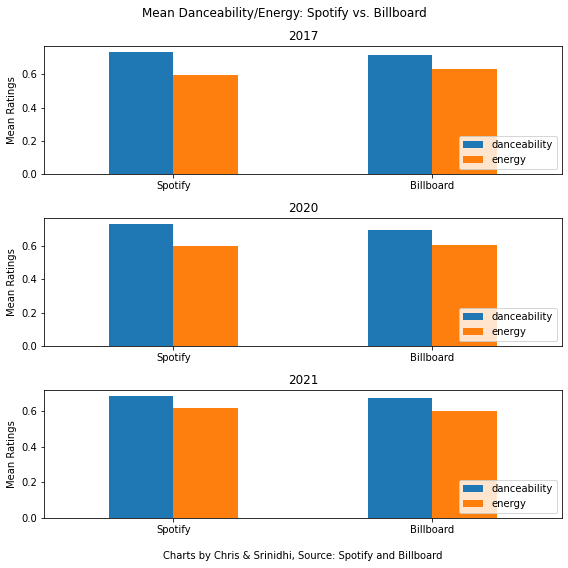

In [7]:
# Plotting the means in three subplots
fig, axs = plt.subplots(3, figsize = (8,8))
fig.suptitle('Mean Danceability/Energy: Spotify vs. Billboard')
axs[0] = de2017_mean_df.plot(kind='bar', rot = 0, ax=axs[0])
axs[1] = de2020_mean_df.plot(kind='bar', rot = 0, ax = axs[1])
axs[2] = de2021_mean_df.plot(kind='bar', rot = 0, ax = axs[2])

axs[0].legend(loc = 'lower right')
axs[0].set_title('2017')
axs[0].set_ylabel('Mean Ratings')
axs[1].legend(loc = 'lower right')
axs[1].set_title('2020')
axs[1].set_ylabel('Mean Ratings')
axs[2].legend(loc = 'lower right')
axs[2].set_title('2021')
axs[2].set_ylabel('Mean Ratings')
axs[2].set_xlabel('\nCharts by Chris & Srinidhi, Source: Spotify and Billboard')
fig.tight_layout()
plt.show()

There is not too much difference between the mean danceability and energy between Spotify and Billboard in 2017 – notice the similarity between the heights of the blue bars and orange bars. This could make sense, as perhaps Spotify, as a streaming-exclusive charts, didn't really start deviating from the Billboard charts until more recent years as more people joined the platform and developed their own listening habits. However, the 2020 and 2021 charts were also incredibly similar in terms of danceability and energy, _contradicting our hypothesis_. 

We also hypothesized that the Spotify charts would have a higher average song duration than the Billboard charts. Due to the economics of radio play and fickle listeners who can easily switch stations, it would make sense if songs popular on Billboard stayed shorter, while songs on Spotify could stretch longer without losing listeners, especially since Spotify's artist pages encourage dedicated fanbases to develop.

Here, we display the mean duration in seconds in all years by platform: 

In [8]:
# Computing means
spotify2017_mean_duration = spotify2017_clean['duration_sec'].mean()
billboard2017_mean_duration = billboard2017_clean['duration_sec'].mean()

spotify2020_mean_duration = spotify2020_clean['duration_sec'].mean()
billboard2020_mean_duration = billboard2020_clean['duration_sec'].mean()

spotify2021_mean_duration = spotify2021_clean['duration_sec'].mean()
billboard2021_mean_duration = billboard2021_clean['duration_sec'].mean()

#create data
data = ["Spotify", spotify2017_clean['duration_sec'].mean(), spotify2020_clean['duration_sec'].mean(), spotify2021_clean['duration_sec'].mean()], ["Billboard", billboard2017_clean['duration_sec'].mean(), billboard2020_clean['duration_sec'].mean(), billboard2021_clean['duration_sec'].mean()]
#display table
print(tabulate(data, headers = ["Chart Mean Duration (sec)", "2017", "2020",  "2021"]))

Chart Mean Duration (sec)       2017     2020     2021
---------------------------  -------  -------  -------
Spotify                      223.075  197.94   194.426
Billboard                    223.301  195.659  192.198


This is interesting - there doesn't seem to be any significant difference in mean song length across charts. See how in 2017, mean song length clusters around 223 seconds; in 2020, it clusters around 196 seconds and in 2021, 193 seconds. Of course, mean song lengths at large decreasing in later years could be due to factors outside the scope of this analysis. 

Here, looking at our inconclusive results in which Billboard and Spotify charts reported very similar metrics, we had a realization. In general, many songs which are popular in the US will be popular across wide swathes of the population - in order words, they will chart on both Spotify and Billboard. **This means that the large overlap in songs between charts may be homogenizing our analyses, resulting in a lack of significant differences in audio characteristics being found.**

What if we isolated our analysis to just the songs which appeared _only_ on the Spotify charts, or _only_ on the Billboard charts, in a particular year? In accordance with our initial question, that way we could accurately examine possible explanations for which characteristics make a song popular in a specific chart over the other. 

### What's on One Chart, But Not the Other?

This shift in thinking revealed so many new possibilities for our analysis! We decided to grab songs which were on only either the Spotify or Billboard charts in 2017, 2020, and 2021. 

Because Spotify only provided the top 50 songs in 2020 and 2021 (they provided 98 songs in 2017), while Billboard provides the top 100 songs each year, we had to slice the 2020 and 2021 Billboard datasets to the top 50 songs so as to make more effective comparisons and not distort our data towards Billboard. To find songs unique to each chart, we merged the Billboard and Spotify datasets by song name (finding songs on both charts), and then pulled out which songs did not appear on the merged list. Quickly realizing that some misalignment on how songs were labeled in different charts, and that Billboard counts all remixes of songs as singular entities encompassing the original song, we checked the lists of songs unique to either chart by hand to find and drop some redundant songs. 

Altogether, we found that: 
- 2017: 29 songs were on the Spotify charts, but not the Billboard charts, 32 songs were on the Billboard charts, but not the Spotify charts.
- 2020: 19 songs Spotify-only, 20 songs Billboard-only
- 2021: 15 songs Spotify-only, 16 songs Billboard-only

Finally, we merged these songs across years to create _two new datasets_ - one for songs which only charted on Spotify in 2017, 2020, and 2021; and one for songs which only charted on Billboard in the same years. Our remaining analysis is conducted on these datasets.

### Merged Unique Song Analysis

As it turns out, analysis of the chart-specific datasets proved to be more fruitful than our previous approach. We were able to run a variety of exploratory analyses to better understand the data and its differences. A few of these analyses will be discussed below:

#### Q1: How do the two charts vary in terms of Spotify's track-level metrics?

First, we wanted to examine if there were any meaningful differences in the audio metrics of the Spotify-only and Billboard-only songs. Due to the large number of metrics, we conducted a k-means cluster analysis on the variables in order to hone in on a few key ones to focus on (for our exact methodology, see **"Merged Unique Song Analysis (Spotify vs. Billboard).ipynb"** in the **"data_analysis"** folder). We decided to include four variables - _acousticness_, _danceability_, _valence_, and _liveness_. Below is a bar graph that compares the means of these metrics between the Spotify and Billboard lists:

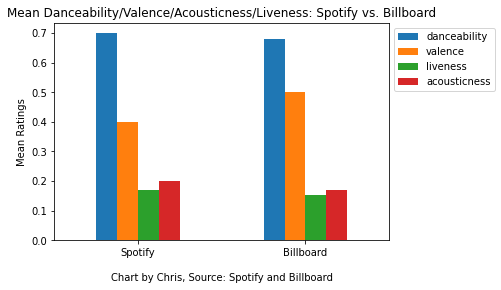

In [23]:
spotify_mean_dance = spotifyonly['danceability'].mean()
spotify_mean_valence = spotifyonly['valence'].mean()
spotify_mean_acous = spotifyonly['acousticness'].mean()
spotify_mean_live = spotifyonly['liveness'].mean()
billboard_mean_dance = billboardonly['danceability'].mean()
billboard_mean_valence = billboardonly['valence'].mean()
billboard_mean_acous = billboardonly['acousticness'].mean()
billboard_mean_live = billboardonly['liveness'].mean()

# Creating new dataframe and plotting
uniquesongdance = [spotify_mean_dance, billboard_mean_dance]
uniquesongvalence = [spotify_mean_valence, billboard_mean_valence]
uniquesongacous = [spotify_mean_acous, billboard_mean_acous]
uniquesonglive = [spotify_mean_live, billboard_mean_live]

index = ['Spotify', 'Billboard']
de_mean_df = pd.DataFrame({
    'danceability' : uniquesongdance, 
    'valence' : uniquesongvalence,
    'liveness' : uniquesonglive,
    'acousticness' : uniquesongacous}, index = index)

de_mean_df.plot.bar(rot = 0)
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Mean Danceability/Valence/Acousticness/Liveness: Spotify vs. Billboard')
plt.ylabel('Mean Ratings')
plt.xlabel('\nChart by Chris Chien, Source: Spotify and Billboard')
plt.show()

We ultimately did not find any significant difference in mean danceability, liveness, or acousticness between the two charts. However, we do observe that the mean valence of the Billboard-only songs is significantly higher that of the Spotify-only songs. Here's a closer look at valence (as well as energy, a variable that has a moderately strong correlation with valence) in the form of side-by-side boxplots:

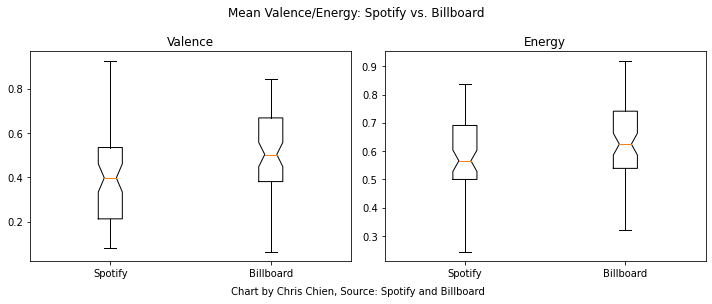

In [35]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))
fig.suptitle('Mean Valence/Energy: Spotify vs. Billboard')
axs[0].boxplot((spotifyonly['valence'], billboardonly['valence']), notch = True)
axs[1].boxplot((spotifyonly['energy'], billboardonly['energy']), notch = True)
axs[0].set_xticklabels(['Spotify', 'Billboard'])
axs[1].set_xticklabels(['Spotify', 'Billboard'])
axs[0].set_title('Valence')
axs[1].set_title('Energy')
fig.text(0.5, 0.01, '\n Chart by Chris Chien, Source: Spotify and Billboard', ha='center', va='center')
fig.tight_layout()
plt.show()

In [11]:
spotify_valmean = spotifyonly['valence'].mean()
billboard_valmean = billboardonly['valence'].mean()
spotify_energymean = spotifyonly['energy'].mean()
billboard_energymean = billboardonly['energy'].mean()
t_val, p_val, df_val = sm.ttest_ind(spotifyonly['valence'], billboardonly['valence'])
t_energy, p_energy, df_energy = sm.ttest_ind(spotifyonly['energy'], billboardonly['energy'])

print(' ' * 27 + 'SPOTIFY' + ' ' * 23 + 'BILLBOARD' + ' ' * 16 + 'T-VALUE' + ' ' * 14 + 'P-VALUE')
print('=' * 115)
print(f'Mean Valence {spotify_valmean:>20.2f} {billboard_valmean:>30.2f} {t_val:>23.2f} {p_val:20.3f}')
print(f'Mean Energy {spotify_energymean:>21.2f} {billboard_energymean:>30.2f} {t_energy:>23.2f} {p_energy:20.3f}')

                           SPOTIFY                       BILLBOARD                T-VALUE              P-VALUE
Mean Valence                 0.40                           0.50                   -2.85                0.005
Mean Energy                  0.58                           0.63                   -1.91                0.058


Here is a more detailed breakdown of the differences. In the above chart, the "SPOTIFY" and "BILLBOARD" columns refer to the mean values of the metric for each list, while the "T-VALUE" and "P-VALUE" columns describe the two-sample t-test statistics ($\alpha$ = 0.05). The difference in mean valence was found to be statistically significant, while the difference in mean energy was on the borderline of significance.

The higher valence and energy of Billboard-only songs makes sense in a real-world context. In today's musical and technological landscape, the convenience and personalization provided by streaming has transformed the public's usage of radio - nowadays most people only listen to it while they're driving. This audience typically seeks out songs that provide "good vibes" (high valence) and are relatively upbeat (high energy). Thus, it makes sense that Billboard's charts, which count both radio and streaming, would consist of songs with higher valence and energy than Spotify's charts.

#### Q2: How do the two charts vary in terms of song duration?

An early hypothesis that we proposed during the initial brainstorming of this research topic concerned a potential difference in song duration between the Spotify and Billboard charts. The influence of short-clip social media platforms such as Tik Tok has led to the rise of relatively short songs that are built around a singular catchy and memeable six-second interval. Meanwhile, practices like radio editing continue to reinforce the homogeneous nature of radio playlists. Thus, we predicted that songs that appear on the streaming-only Spotify chart would be shorter than songs that appear on the Billboard chart. We also predicted that the Billboard chart would cluster around a specific average duration (between 210-240 seconds), while the Spotify chart would have greater diversity in song duration. However, we did not find such trends in the data. Below displays a group of histograms that visualize the distribution of song durations in each dataset:

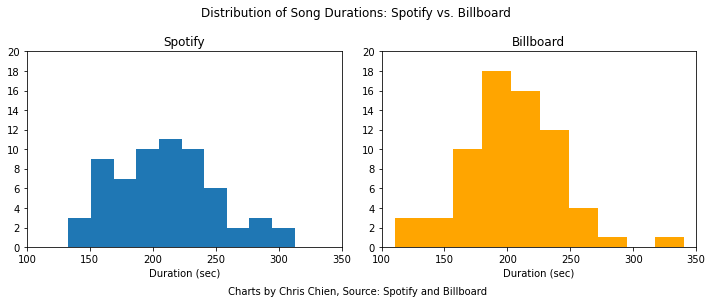

In [36]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))
fig.suptitle('Distribution of Song Durations: Spotify vs. Billboard')
axs[0].hist(spotifyonly['duration_sec'])
axs[1].hist(billboardonly['duration_sec'], color = 'orange')
axs[0].set_title('Spotify')
axs[0].set_xlabel('Duration (sec)')
axs[0].set_xlim(100, 350)
axs[0].set_ylim(0, 20)
axs[0].locator_params(axis = "y", nbins = 10)
axs[1].set_title('Billboard')
axs[1].set_xlabel('Duration (sec)')
axs[1].set_xlim(100, 350)
axs[1].set_ylim(0, 20)
axs[1].locator_params(axis = "y", nbins = 10)
fig.text(0.5, 0.01, '\n Charts by Chris Chien, Source: Spotify and Billboard', ha='center', va='center')
fig.tight_layout()
plt.show()

As can be seen, the shape of the distributions are relatively similar. Although it appears that the Billboard chart has a stronger cluster around the average song length, these differences were not found to be statistically significant. One interesting observation is the presence of outliers on both the short and long end of song duration on the Billboard chart. This seems to contradict our original hypothesis of the Billboard chart having less variety in song duration. Ultimately, we did not observe any significant difference in song duration between the Spotify and Billboard charts.

### Summary of Findings

### Takeaways: What Does It All Mean?